# Analysis of Logistic Regression models trained with _arg_ features (from argument research)

+ on 10000 instances
+ on same splits as for the transformers models

*features are extracted with the tools in `ArgQualityAdapters/`

These models are not great, they have a max accuracy of `0.63` which is also the percentage of the majority label. However, the models are still usable as they do not always predict the majority label (see `preds/` and `f1` related scores below).

They are useful for understanding which features extracted with tools from argument research (`arg`) are considered important.

In [1]:
f = 378
t = 622

f_percentage = round(f / (f + t) * 100, 2)
t_percentage = round(t / (f + t) * 100, 2)

print(f"False: {f} ({f_percentage}%)")
print(f"True: {t} ({t_percentage}%)")

False: 378 (37.8%)
True: 622 (62.2%)


In [2]:
import os
import json
import pandas as pd
import pprint as pp

In [3]:
PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
STATS_DIR = os.path.join(PROJECT_DIR, "classification/stats/")

PROJECT_DIR

'/mount/studenten-temp1/users/dpgo/xai-thesis'

In [4]:
run_file_map = {
    'all': os.path.join(STATS_DIR, "12091031_all_arg_10000.json"),
    'kbest-rfe-ensemble': os.path.join(STATS_DIR, "12091031_kbest-rfe-ensemble_arg_10000.json"),
}

In [5]:
def visualize_results(stats_file, n_features=10):
    
    # load file with results
    with open(os.path.join(PROJECT_DIR, stats_file), "r") as f:
        stats = json.load(f)
        coef_dict, scores_dict = stats['coefficients'], stats['scores']

    # metrics
    # round floats in scores_dict to 2 decimals
    for key, value in scores_dict.items():
        if isinstance(value, float):
            scores_dict[key] = round(value, 2)
        elif isinstance(value, dict):
            for inner_key, inner_value in value.items():
                if isinstance(inner_value, float):
                    scores_dict[key][inner_key] = round(inner_value, 2)
                if inner_key == 'support':
                    scores_dict[key][inner_key] = int(inner_value)
    
    #pp.pprint(scores_dict, indent=4)
    
    # feature importances
    coef_df = pd.DataFrame(coef_dict.items(), columns=['feature', 'coefficient'])
    coef_df = coef_df.sort_values(by='coefficient', ascending=False)

    top_n_pos_features = coef_df.head(n_features)
    top_n_neg_features = coef_df.tail(n_features)
    top_features_df = pd.merge(top_n_pos_features, top_n_neg_features, how='outer')

    top_features_df.plot(x='feature', y='coefficient', kind='barh', figsize=(20, 10))

    return top_features_df

## All extracted features (no selection)

|          | precision | recall | f1-score | support |
|----------|-----------|--------|----------|---------|
| accuracy | 0.63      |        |          | 1000.0  |
| macro avg | 0.59      | 0.56   | 0.54     | 1000.0  |
| weighted avg | 0.60   | 0.63   | 0.59     | 1000.0  |
| False    | 0.52      | 0.26   | 0.35     | 378.0   |
| True     | 0.66      | 0.86   | 0.74     | 622.0   |

#### Number of features = 32

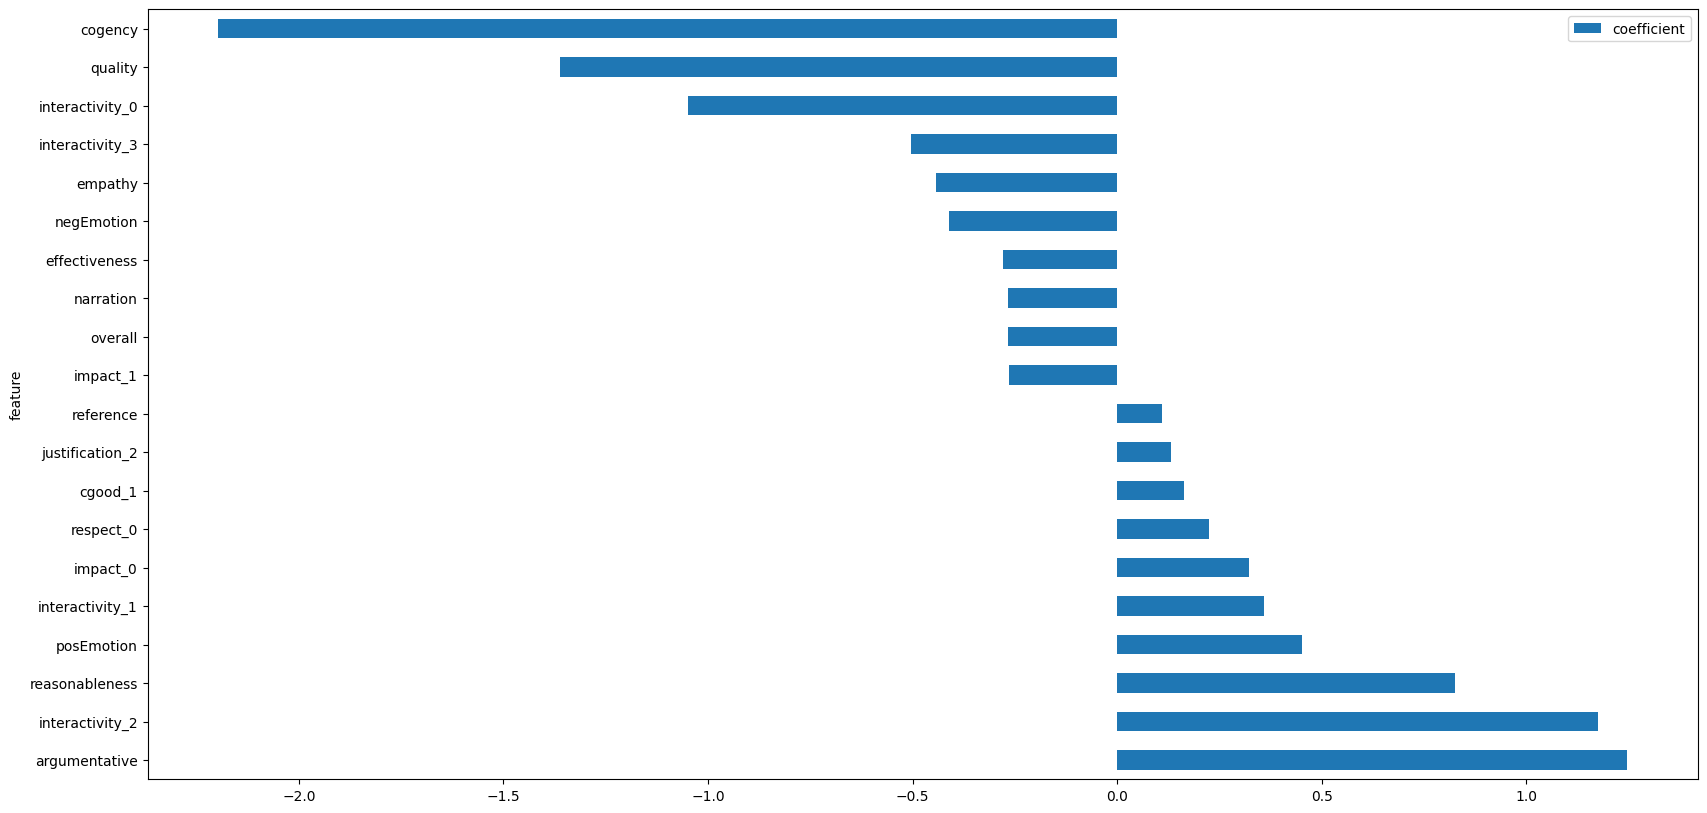

In [6]:
top_all = visualize_results(run_file_map['all'], n_features=10)

## RFE + KBest Selection (chi2); Ensemble

throrough feature selection
+ kbest runs chi2 test
+ RFE is prediction based
+ the two sets are ensembled (only features that appear in both sets are kept)


|          | precision | recall | f1-score | support |
|----------|-----------|--------|----------|---------|
| accuracy | 0.63      |        |          | 1000.0  |
| macro avg | 0.59      | 0.56   | 0.54     | 1000.0  |
| weighted avg | 0.61   | 0.63   | 0.59     | 1000.0  |
| False    | 0.53      | 0.25   | 0.34     | 378.0   |
| True     | 0.65      | 0.86   | 0.74     | 622.0   |

#### Number of features = 9

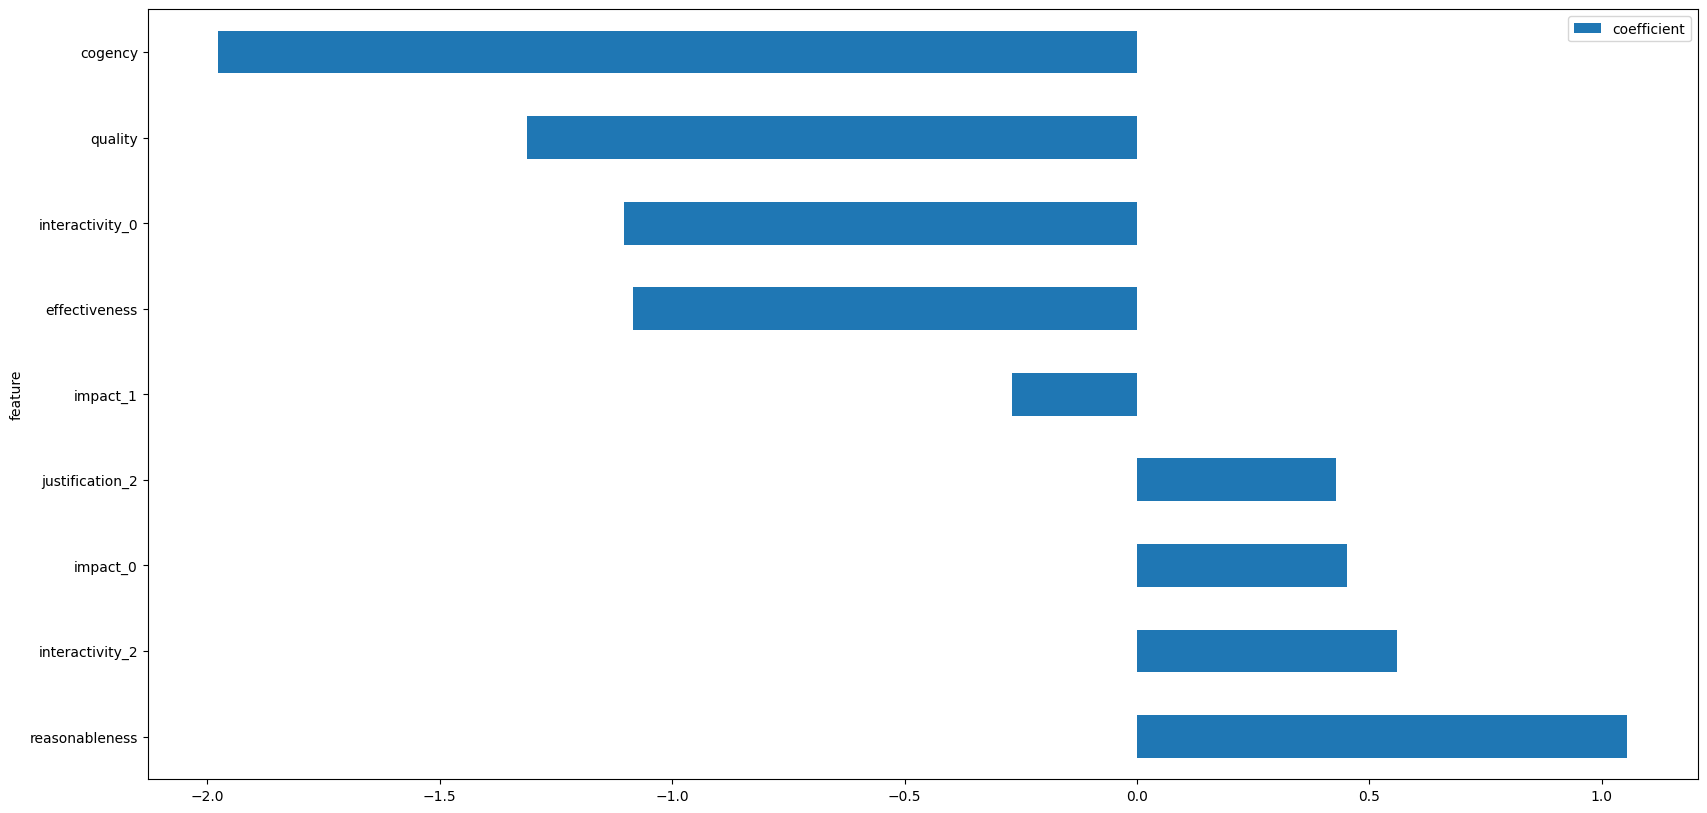

In [7]:
top_kbest_rfe_ensemble = visualize_results(run_file_map['kbest-rfe-ensemble'], n_features=5)

## Feature interpretation

#### Negative class

+ cogency: acceptable and sufficient premises to draw a conclusion (score (1-5); GAQ)
    - logical dimension,
    - measures whether an argument has premises and a valid conclusion thus takes the content and structure of a single argument into account.
+ quality: general argument quality (score 0-1; from IBM-Rank-30k)
+ interactivity_0: respect towards other participants, reference to other participants arguments (multi-class (4); Europolis)
+ effectiveness: persuasion, rethorical, emotional appeal (score (1-5); GAQ)
    - rhetorical dimension,
    - measures the persuasiveness of the argument and takes into account how it is presented (style, emotional appeal),

*`cogengy`, `quality` also show as important features for models trained on `all` features

#### Positive class

+ reasonableness: contribution to resolution of issues, argument is accepted by universal audience (score (1-5); GAQ)
    - dialectical dimension,
    - plays a more important role in the context of a discourse and reflects whether an argument is valid towards a universal audience (e.g. whether the reasoning is based on values generally accepted by the society) or whether it is constructive in helping to resolve issues.

## Features analysis

In [10]:
FEATURES_DIR = os.path.join(PROJECT_DIR, "feature_extraction/features")
arg_features_file = os.path.join(FEATURES_DIR, "12091031_arg_features_allscores.csv.gz")

arg_features_df = pd.read_csv(arg_features_file, compression='gzip')
arg_features_df # contains full dataset

,idx,reasonableness,effectiveness,overall,impact_0,impact_1,impact_2,quality,clarity,justification_0,...,negEmotion,empathy,argumentative,narration,proposal,QforJustification,cogency,respect_0,respect_1,respect_2
0,0,3.341723,3.459739,3.490469,0.554465,0.000002,0.445533,0.790797,0.469862,0.152375,...,0.185586,0.000678,0.359935,0.317898,0.170279,0.417538,3.499280,0.017156,0.873495,0.109349
1,1,3.310717,3.407925,3.510574,0.878104,0.000032,0.121864,0.771100,0.522841,0.106056,...,0.128852,0.000675,0.688089,0.547023,0.123410,0.408935,3.670717,0.042282,0.861298,0.096419
2,2,3.309243,3.528578,3.437755,0.167201,0.000010,0.832789,0.721664,0.473248,0.405487,...,0.087966,0.000821,0.286424,0.422823,0.681252,0.443184,3.396432,0.001442,0.961977,0.036581
3,3,2.850797,2.949182,2.864886,0.723745,0.000175,0.276080,0.826384,0.493190,0.682942,...,0.085762,0.000561,0.401220,0.393091,0.016177,0.431267,2.893239,0.008200,0.966405,0.025395
4,4,3.021952,3.426721,3.296667,0.656852,0.000203,0.342945,0.797320,0.575050,0.116434,...,0.084651,0.000734,0.530441,0.430711,0.101419,0.433558,3.386074,0.055834,0.673849,0.270317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,2.967011,3.164004,3.171266,0.925430,0.000001,0.074569,0.784907,0.593525,0.053681,...,0.360860,0.000651,0.575387,0.358940,0.008720,0.423947,3.234965,0.015245,0.906674,0.078080
9996,9996,3.140424,3.227793,3.305011,0.000462,0.745743,0.253795,0.746220,0.457729,0.801039,...,0.105335,0.000463,0.325945,0.394665,0.026037,0.436281,3.266778,0.000752,0.974519,0.024730
9997,9997,3.457392,3.572265,3.639871,0.830486,0.000044,0.169470,0.810357,0.539407,0.332568,...,0.092926,0.000489,0.571387,0.471443,0.803791,0.412957,3.779137,0.017302,0.869085,0.113613
9998,9998,3.340814,3.495708,3.499193,0.134098,0.000001,0.865901,0.713163,0.505506,0.182731,...,0.115811,0.000478,0.413053,0.368973,0.550599,0.442973,3.640540,0.003914,0.944874,0.051212


In [22]:
# Instances with highest cogency score (overall; full dataset)
arg_features_df['cogency'].sort_values(ascending=False)

6400    4.239473
1289    4.161296
6327    4.128531
245     4.116751
2051    4.100712
          ...   
1018    2.195189
3641    2.188138
1551    2.186373
9166    2.162878
1579    2.095238
Name: cogency, Length: 10000, dtype: float64

In [95]:
# Mean and variance for the relevant features (full dataset)
arg_features_df[['cogency', 'quality', 'effectiveness', 'interactivity_0', 'reasonableness']].describe()

,cogency,quality,effectiveness,interactivity_0,reasonableness
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.306492,0.755338,3.196403,0.267990,3.062529
std,0.330030,0.078102,0.336578,0.075440,0.305943
min,2.095238,0.343227,2.117596,0.071035,1.907353
25%,3.082536,0.713036,2.978005,0.213763,2.868451
50%,3.350672,0.762941,3.212196,0.261551,3.084337
75%,3.555446,0.806260,3.429326,0.315520,3.271481
max,4.239473,0.987474,4.313773,0.607730,4.033853


In [14]:
from datasets import load_from_disk

SPLITS_DIR = os.path.join(PROJECT_DIR, "classification/split_datasets/coqa")
test_data = load_from_disk(os.path.join(SPLITS_DIR))['test']

In [19]:
arg_features_test_df = arg_features_df[arg_features_df['idx'].isin(test_data['pandas_idx'])]
arg_features_test_df # contains test instances only

,idx,reasonableness,effectiveness,overall,impact_0,impact_1,impact_2,quality,clarity,justification_0,...,negEmotion,empathy,argumentative,narration,proposal,QforJustification,cogency,respect_0,respect_1,respect_2
0,0,3.341723,3.459739,3.490469,0.554465,0.000002,0.445533,0.790797,0.469862,0.152375,...,0.185586,0.000678,0.359935,0.317898,0.170279,0.417538,3.499280,0.017156,0.873495,0.109349
3,3,2.850797,2.949182,2.864886,0.723745,0.000175,0.276080,0.826384,0.493190,0.682942,...,0.085762,0.000561,0.401220,0.393091,0.016177,0.431267,2.893239,0.008200,0.966405,0.025395
17,17,3.645230,3.615971,3.709445,0.248244,0.000032,0.751724,0.748112,0.403873,0.340335,...,0.080397,0.000502,0.443346,0.463372,0.040414,0.452351,3.567401,0.004012,0.943950,0.052039
23,23,3.195433,3.493968,3.467871,0.583706,0.000030,0.416265,0.767830,0.551150,0.069720,...,0.535930,0.001281,0.447452,0.422962,0.010902,0.429808,3.579115,0.071662,0.308659,0.619680
35,35,3.595420,3.640256,3.616954,0.015501,0.000136,0.984363,0.826113,0.480436,0.288843,...,0.070949,0.000504,0.509618,0.435279,0.036421,0.440443,3.560410,0.001551,0.930313,0.068136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9972,9972,3.311148,3.359223,3.532951,0.122217,0.000141,0.877642,0.761413,0.469482,0.177515,...,0.132514,0.000480,0.418850,0.354038,0.965148,0.428818,3.527643,0.002670,0.958374,0.038956
9975,9975,3.368371,3.577850,3.628868,0.603922,0.000007,0.396071,0.729382,0.493969,0.027478,...,0.401331,0.000491,0.382672,0.430165,0.046827,0.426230,3.708337,0.007569,0.581997,0.410434
9989,9989,2.562615,2.806117,2.847770,0.391293,0.000008,0.608698,0.678998,0.411802,0.246167,...,0.288605,0.001651,0.492272,0.394293,0.006379,0.426526,2.741968,0.001492,0.708760,0.289747
9993,9993,2.999806,3.118227,3.121287,0.503730,0.000005,0.496265,0.764867,0.526343,0.619963,...,0.069759,0.000617,0.414611,0.390188,0.009707,0.458484,3.275364,0.002172,0.993000,0.004828


In [ ]:
PREDS_DIR = os.path.join(PROJECT_DIR, "classification/preds")
preds_file = os.path.join(PREDS_DIR, "preds_12091031_all_arg.json")
    
preds_df = pd.read_json(preds_file, orient='index')
preds_df.columns = ['pred']
preds_df['pred'] = preds_df['pred'].astype(int)

arg_features_test_df = pd.merge(arg_features_test_df, preds_df, how='outer', left_index=True, right_index=True)

In [44]:
# Calculate correlation between important features and prediction
arg_features_test_df[['cogency', 'quality', 'reasonableness', 'interactivity_0', 'effectiveness', 'pred']].corr()

,cogency,quality,reasonableness,interactivity_0,effectiveness,pred
cogency,1.000000,0.630032,0.933693,0.324418,0.883283,-0.459884
quality,0.630032,1.000000,0.686244,0.339078,0.731833,-0.448041
reasonableness,0.933693,0.686244,1.000000,0.380950,0.920910,-0.507476
interactivity_0,0.324418,0.339078,0.380950,1.000000,0.397761,-0.398239
effectiveness,0.883283,0.731833,0.920910,0.397761,1.000000,-0.556969
pred,-0.459884,-0.448041,-0.507476,-0.398239,-0.556969,1.000000


In [53]:
arg_features_test_df['pred'].value_counts() # general distribution of predictions

pred
1    812
0    188
Name: count, dtype: int64

### Cogency (0)

In [21]:
# Instances with highest cogency score (in the test set)
arg_features_test_df['cogency'].sort_values(ascending=False)

2473    4.014459
3742    3.980128
5466    3.963124
3411    3.953437
1747    3.949787
          ...   
1671    2.375369
6289    2.341164
8355    2.264088
7261    2.261385
367     2.237230
Name: cogency, Length: 1000, dtype: float64

In [96]:
arg_features_df['cogency'].mean()

3.3064920128822326

In [111]:
arg_features_test_df[arg_features_test_df['cogency'] > 3.3]['pred'].value_counts()

pred
1    368
0    174
Name: count, dtype: int64

In [113]:
arg_features_test_df[arg_features_test_df['cogency'] > 3.7]['pred'].value_counts()

pred
0    72
1    39
Name: count, dtype: int64

In [115]:
arg_features_test_df[arg_features_test_df['cogency'] < 3]['pred'].value_counts()

pred
1    212
Name: count, dtype: int64

In [116]:
arg_features_test_df[arg_features_test_df['cogency'] < 2.5]['pred'].value_counts()

pred
1    14
Name: count, dtype: int64

174 out of 188 instances predicted as negative have a cogency score above average.

For significantly above average values, we see a majority of negative predictions.

But many positive predictions also have a high value for cogency, which means that it is not necessarily an indicator of the negative class. 

There are also 212 instances that have a low(er) value for cogency are actually predicted as positive (and 14 instances with low (<2.5) cogency score are predicted as postive)

### Quality (0)

In [56]:
arg_features_test_df['quality'].sort_values(ascending=False)

1864    0.961266
3429    0.933306
764     0.923483
9860    0.917884
9709    0.917528
          ...   
6033    0.475039
1392    0.460066
5071    0.427361
9696    0.419722
367     0.377844
Name: quality, Length: 1000, dtype: float64

In [117]:
arg_features_df['quality'].mean()

0.7553381288319826

In [118]:
# check how many predictions for each class (0 and 1) there are when quality is more than 0.5
arg_features_test_df[arg_features_test_df['quality'] > 0.75]['pred'].value_counts()

pred
1    396
0    179
Name: count, dtype: int64

In [120]:
arg_features_test_df[arg_features_test_df['quality'] > 0.85]['pred'].value_counts()

pred
0    59
1    30
Name: count, dtype: int64

In [124]:
arg_features_test_df[arg_features_test_df['quality'] <= 0.65]['pred'].value_counts()

pred
1    88
Name: count, dtype: int64

179 out of 188 negative predictions have an above avg value of quality.

But so do 396 positive predictions.

When looking at significantly above avg scores, there is a strong majority of negative predictions.

When looking at significantly below avg score, all instances are positive predictions.

### Effectiveness (0)

In [79]:
arg_features_test_df['effectiveness'].sort_values(ascending=False)

5570    4.164463
8674    4.079695
1328    3.999676
7087    3.994215
2145    3.991894
          ...   
8355    2.291710
5071    2.284817
96      2.280720
367     2.130946
1768    2.117596
Name: effectiveness, Length: 1000, dtype: float64

In [131]:
arg_features_df['effectiveness'].mean()

3.1964031107902526

In [132]:
arg_features_test_df[arg_features_test_df['effectiveness'] > 3.19]['pred'].value_counts()

pred
1    322
0    186
Name: count, dtype: int64

In [126]:
arg_features_test_df[arg_features_test_df['effectiveness'] > 3.6]['pred'].value_counts()

pred
0    84
1    21
Name: count, dtype: int64

In [127]:
arg_features_test_df[arg_features_test_df['effectiveness'] < 2.8]['pred'].value_counts()

pred
1    145
Name: count, dtype: int64

All negative predictions (except 2) have an above avg value of effectiveness.

But so do 322 out of 812 positive predictions.

When looking at significantly above avg scores, there is a strong majority of negative predictions.

When looking at significantly below avg predictions, they are all positive.

### Reasonableness (1)

In [82]:
arg_features_test_df['reasonableness'].sort_values(ascending=False)

8020    3.835304
6454    3.825253
2473    3.817167
2145    3.796152
1747    3.795850
          ...   
6329    2.125837
96      2.118864
6289    2.112822
8355    1.931856
367     1.907353
Name: reasonableness, Length: 1000, dtype: float64

In [130]:
arg_features_df['reasonableness'].mean()

3.062528920781612

In [133]:
arg_features_test_df[arg_features_test_df['reasonableness'] > 3.06]['pred'].value_counts()

pred
1    334
0    180
Name: count, dtype: int64

In [134]:
arg_features_test_df[arg_features_test_df['reasonableness'] > 3.5]['pred'].value_counts()

pred
0    50
1    15
Name: count, dtype: int64

In [136]:
arg_features_test_df[arg_features_test_df['reasonableness'] < 2.6]['pred'].value_counts()

pred
1    88
Name: count, dtype: int64

All negative predictions (except 8) have an above avg value of reasonableness.

But so do 334 out of 812 positive predictions.

When looking at significantly above avg scores, there is a strong majority of negative predictions.

When looking at significantly below avg predictions, they are all positive.

!! From analysing reasonableness (possible indicator of the positive class) we get a very similar outcome as for the other features (which are possible indicators of the negative class) 